# Exploratory Data Analysis (EDA) for Azerbaijani NER Dataset

This notebook performs an Exploratory Data Analysis (EDA) on the Azerbaijani Named Entity Recognition (NER) dataset. The goal is to understand the characteristics of the dataset, including data distribution, entity types, and potential challenges for model training.

In [1]:
# Import necessary libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter

# Add the project root to sys.path to import local modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.utils.helpers import load_config
from src.data.dataset_loader import load_hf_dataset, get_label_mapping
from transformers import AutoTokenizer

warnings.filterwarnings("ignore")

d:\LLM Projects\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Configuration and Data Loading

First, we load the model configuration and the dataset.

In [2]:
# Load configurations
model_config = load_config("../configs/model_config.yaml")
training_config = load_config("../configs/training_config.yaml") # Needed for seed and subset size

# Load dataset
dataset = load_hf_dataset(model_config["dataset_name"])

# Apply subsetting to training data if configured in training_config
if "train" in dataset and "train_subset_size" in training_config and training_config["train_subset_size"] < 1.0:
    original_train_size = len(dataset["train"])
    dataset["train"] = dataset["train"].shuffle(seed=training_config["seed"]).select(range(int(original_train_size * training_config["train_subset_size"])))

## 2. Dataset Overview

Let's inspect the dataset structure and sizes of each split.

In [3]:
print("Dataset structure:", dataset)
for split_name, split_data in dataset.items():
    print(f"Split: {split_name}, Size: {len(split_data)} examples")

print("\nFirst example from training split:")
print(dataset["train"][0])

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 15357
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 9579
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 9602
    })
})
Split: train, Size: 15357 examples
Split: validation, Size: 9579 examples
Split: test, Size: 9602 examples

First example from training split:
{'tokens': ['Rabitəbank', ',', 'Azərbaycanın', '16', 'regionu', 'və', 'Bakı', 'şəhərində', '25', 'xidmət', 'məntəqəsi', 'və', '68', 'ATM-i', ',', 'Rabitəbank', 'Mobile', 'adlı', 'mobil', 'əlavəsi', ',', 'İnternet', 'Bankinq', 'və', 'RabitaBot', 'adlı', 'çatbotu', ',', '133', 'nömrəli', 'Çağrı', 'Mərkəzi', 'ilə', 'müştərilərin', 'xidmətindədir', '.'], 'ner_tags': [3, 0, 14, 17, 0, 0, 14, 0, 17, 0, 0, 0, 17, 8, 0, 3, 9, 0, 9, 0, 0, 9, 9, 0, 9, 0, 9, 0, 17, 0, 0, 0, 0, 0, 0, 0]}


## 3. Label Distribution

Analyze the distribution of NER tags across the dataset.

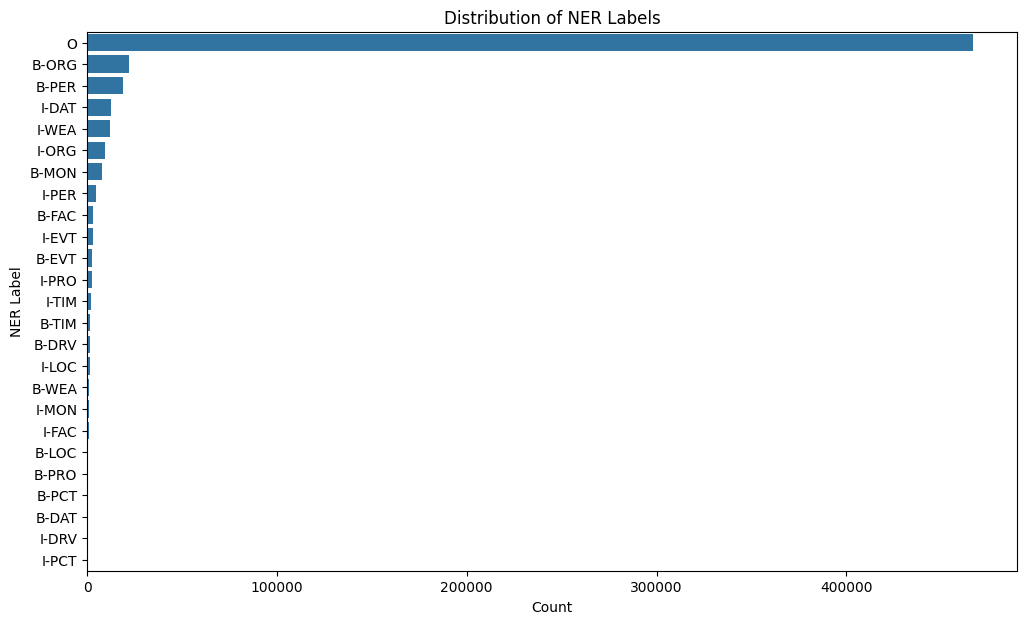

Label counts:
    Label   Count
1       O  466582
0   B-ORG   22339
8   B-PER   19073
2   I-DAT   12548
13  I-WEA   12188
6   I-ORG    9393
3   B-MON    7888
16  I-PER    4821
15  B-FAC    3034
11  I-EVT    2893
5   B-EVT    2858
4   I-PRO    2835
9   I-TIM    2143
7   B-TIM    1763
20  B-DRV    1628
14  I-LOC    1404
17  B-WEA    1191
10  I-MON    1100
18  I-FAC     841
19  B-LOC     750
23  B-PRO     464
22  B-PCT     189
12  B-DAT     185
21  I-DRV     163
24  I-PCT     105


In [4]:
id2label, label2id = get_label_mapping(model_config["label_list"])
label_names = list(label2id.keys())

all_labels = []
for split in dataset.keys():
    for example in dataset[split]:
        all_labels.extend([id2label[tag] for tag in example["ner_tags"]])

label_counts = Counter(all_labels)
label_df = pd.DataFrame(label_counts.items(), columns=['Label', 'Count']).sort_values(by='Count', ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x='Count', y='Label', data=label_df)
plt.title('Distribution of NER Labels')
plt.xlabel('Count')
plt.ylabel('NER Label')
plt.show()

print("Label counts:")
print(label_df)

## 4. Token Length Distribution

Understanding the length of token sequences can help in setting appropriate `max_seq_length` for tokenization.

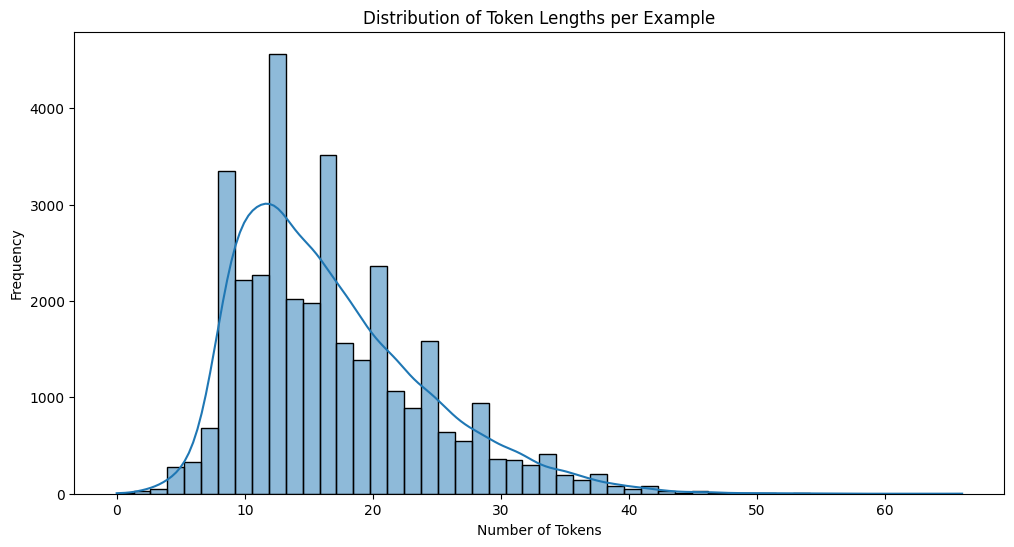

Max token length: 66
Min token length: 0
Average token length: 16.75
95th percentile token length: 31.00


In [5]:
all_token_lengths = []
for split in dataset.keys():
    for example in dataset[split]:
        all_token_lengths.append(len(example["tokens"]))

plt.figure(figsize=(12, 6))
sns.histplot(all_token_lengths, bins=50, kde=True)
plt.title('Distribution of Token Lengths per Example')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

print(f"Max token length: {np.max(all_token_lengths)}")
print(f"Min token length: {np.min(all_token_lengths)}")
print(f"Average token length: {np.mean(all_token_lengths):.2f}")
print(f"95th percentile token length: {np.percentile(all_token_lengths, 95):.2f}")

## 5. Entity Span Length Distribution

How long are the actual named entities (in terms of words)?

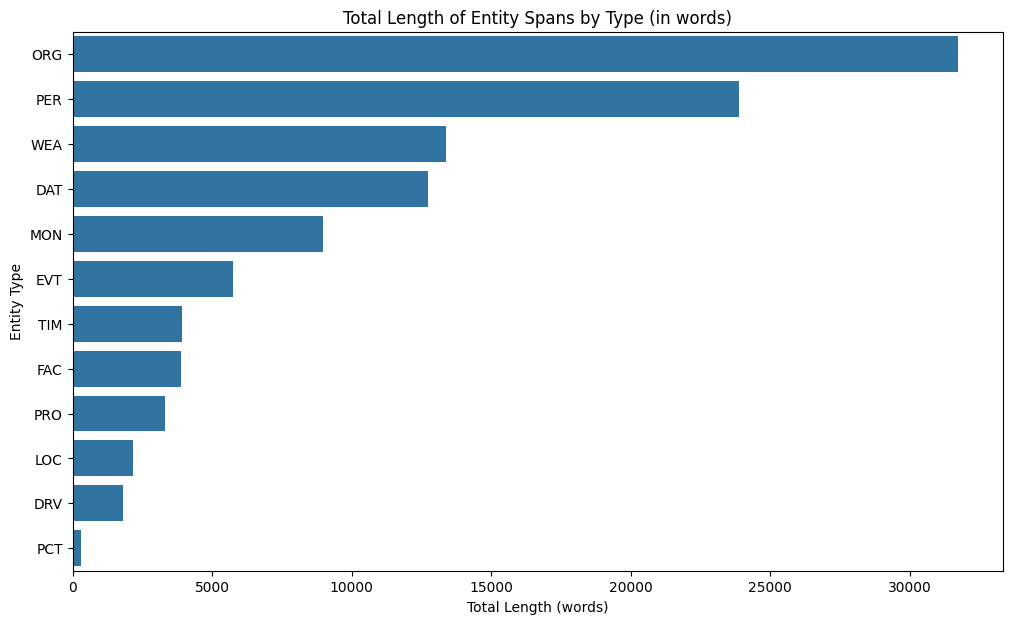

Total length of entity spans:
   Entity Type  Total Length
0          ORG         31732
6          PER         23894
7          WEA         13379
1          DAT         12733
2          MON          8988
4          EVT          5751
5          TIM          3906
9          FAC          3875
3          PRO          3299
8          LOC          2154
10         DRV          1791
11         PCT           294


In [6]:
entity_lengths = Counter()
for split in dataset.keys():
    for example in dataset[split]:
        tokens = example["tokens"]
        ner_tags = example["ner_tags"]
        
        current_entity_type = None
        current_entity_start = -1
        
        for i, tag_id in enumerate(ner_tags):
            tag = id2label[tag_id]
            if tag.startswith("B-"):
                if current_entity_type is not None:
                    # End previous entity
                    length = i - current_entity_start
                    entity_lengths[current_entity_type] += length
                current_entity_type = tag[2:] # Remove B-
                current_entity_start = i
            elif tag.startswith("I-"):
                # Continue current entity, check if type matches
                if current_entity_type is not None and current_entity_type == tag[2:]:
                    pass # Still part of the same entity
                else:
                    # Malformed tag or I-tag without B-tag, treat as new entity or ignore
                    if current_entity_type is not None:
                        length = i - current_entity_start
                        entity_lengths[current_entity_type] += length
                    current_entity_type = tag[2:]
                    current_entity_start = i
            else: # O tag
                if current_entity_type is not None:
                    length = i - current_entity_start
                    entity_lengths[current_entity_type] += length
                current_entity_type = None
                current_entity_start = -1
        
        # Handle entity at the end of the sentence
        if current_entity_type is not None:
            length = len(tokens) - current_entity_start
            entity_lengths[current_entity_type] += length

entity_length_df = pd.DataFrame(entity_lengths.items(), columns=['Entity Type', 'Total Length']).sort_values(by='Total Length', ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x='Total Length', y='Entity Type', data=entity_length_df)
plt.title('Total Length of Entity Spans by Type (in words)')
plt.xlabel('Total Length (words)')
plt.ylabel('Entity Type')
plt.show()

print("Total length of entity spans:")
print(entity_length_df)